# Stocks Prediction

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import yfinance as yf

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [95]:
from typing import Dict, List, Sequence, Set, Tuple, Callable, Union

In [96]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_theme(style='darkgrid')

In [97]:
!python --version

Python 3.8.8


## Downloading Data

Firstly let's implement function which downloads stock data from yahoo finance. Also, we must preproccess data before using ML algorithms. There are some **important things**, which must be done:


1. We should divide downloading and preprocessing stages into different functions, because we will probably use raw data for experiments with preproccessing. It will save our time in future.


2. When working with stocks time series, it is convenient to use price changes. In this case we will use logarithmic returns.


3. Time series forecasting implies using previous values to predict the current one, therefore we should assign lagged values to each target.

In [103]:
def download_stock_data(ticker: str, period: str,
                           interval: str, info_type: Union[str, List[str]] = 'Close') -> pd.Series:
    
    tick = yf.Ticker(ticker)
    X = tick.history(period=period, 
                     interval=interval)[info_type]
    
    return X
    

def preproccess_stock_data(X: str, lags: Union[int, Sequence[int]],
                    log_ret: bool = True, 
                    drop_na: bool = True,
                    drop_index: bool = False) -> pd.DataFrame:
    
    # making up the names for features in the dataset
    # y_i - target value with lag i
    # y - target value to be predicted
    X_new = X.copy()
    
    colnames = [f'y_{lag}' if lag > 0 else f'y' for lag in range(lags + 1)]
    if log_ret:
        X_new = np.log(X_new) - np.log(X_new.shift(1))
    
    X_new = pd.concat([X_new.shift(lag) for lag in range(lags + 1)], axis=1, keys=colnames)
    
    # when we do shift, there are omissions in the objects at the beginning
    # so, if we set drop_na flag, we will drop such objects
    if drop_na:
        # last feature has the largest number of gaps at the beginning
        # so first_valid_index is defined by this column
        first_idx = X_new.iloc[:, -1].first_valid_index()
        X_new = X_new.loc[first_idx:]
    return X_new

## EDA

For example, let's download prices history for Microsoft, which ticker is MSFT.

In [303]:
X = download_stock_data('MSFT', '1Y', '1d')
X_preproccessed = preproccess_stock_data(X, 5, log_ret=True)
X_preproccessed

y       y_1       y_2       y_3       y_4       y_5
Date                                                                  
2021-09-07 -0.003193 -0.000033 -0.002256 -0.000166 -0.005648  0.012829
2021-09-08  0.000100 -0.003193 -0.000033 -0.002256 -0.000166 -0.005648
2021-09-09 -0.009909  0.000100 -0.003193 -0.000033 -0.002256 -0.000166
2021-09-10 -0.005194 -0.009909  0.000100 -0.003193 -0.000033 -0.002256
2021-09-13  0.004319 -0.005194 -0.009909  0.000100 -0.003193 -0.000033
...              ...       ...       ...       ...       ...       ...
2022-08-22 -0.029795 -0.013951 -0.003955 -0.002640 -0.002593  0.005330
2022-08-23 -0.004728 -0.029795 -0.013951 -0.003955 -0.002640 -0.002593
2022-08-24 -0.002354 -0.004728 -0.029795 -0.013951 -0.003955 -0.002640
2022-08-25  0.011034 -0.002354 -0.004728 -0.029795 -0.013951 -0.003955
2022-08-26 -0.039351  0.011034 -0.002354 -0.004728 -0.029795 -0.013951

[246 rows x 6 columns]

Now, when we got preproccesed data, let's compare returns and prices time series plots.

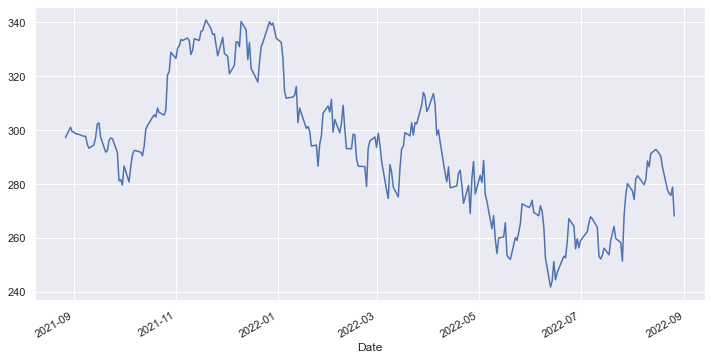

In [305]:
X.plot();

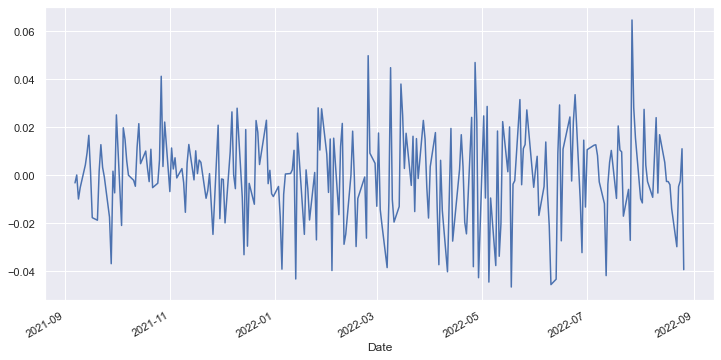

In [306]:
X_preproccessed.y.plot();

As can be seen, returns plot much less informative than prices plot. But the former is more convenient for forecasting for some reasons. Let's continue comparison.

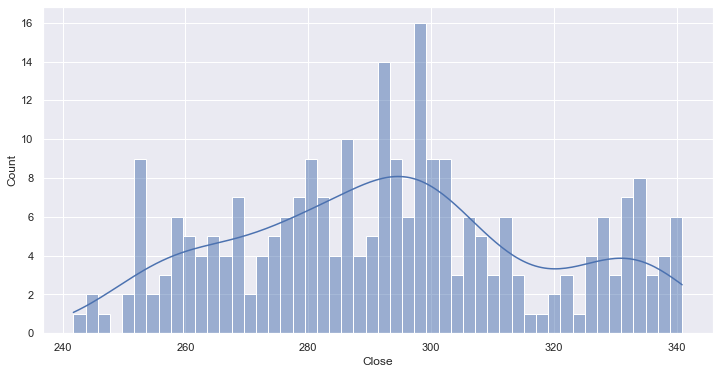

In [307]:
sns.histplot(X, kde=True, bins=50, );

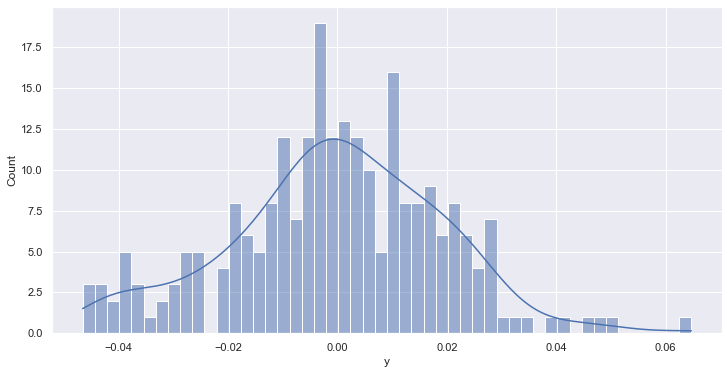

In [308]:
sns.histplot(X_preproccessed.y, kde=True, bins=50);

### To be implemented (description) !!!!!!!!!!!!!!

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X_preproccessed.drop(['y'], axis=1), X_preproccessed['y'], 
                                                    test_size=0.2, shuffle=False)

## Data preparation

In [310]:
X = download_stock_data('MSFT', '2Y', '1h')
X_preproccessed = preproccess_stock_data(X, 70, log_ret=False)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X_preproccessed.drop(['y'], axis=1), X_preproccessed['y'], 
                                                    test_size=0.2, shuffle=False)

In [312]:
tscv = TimeSeriesSplit(n_splits=20)

In [313]:
import sklearn
from sklearn.metrics import r2_score
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

## Baseline model

In [314]:
def train_model(EstimatorCls, *args, **kwargs):
    model = EstimatorCls(*args, **kwargs)
    model.fit(X_train, y_train)
    print('Best score:', model.best_score_)
    print('Best alpha:', model.alpha_)
    return model


def validate_model(model, X, y, scorers):
    scores = []
    y_pred = model.predict(X)
    for scorer in scorers:
        score = scorer(y, y_pred)
        print(scorer.__name__, round(score, 5))
        scores.append(score)        
    return y_pred, scores


def predict_sequence(model, initial_values, 
                     steps = 10):
    values = [list(initial_values)]
    predictions = []
    for _ in range(steps):
        predicted_value = model.predict(values)[0]
        predictions.append(predicted_value)
        values[0].pop(0)
        values[0].append(predicted_value)
    return predictions

In [315]:
model = train_model(RidgeCV, cv=tscv, scoring='r2', alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0))

Best score: 0.9205562479066616
Best alpha: 10.0


In [316]:
print('Test')
y_test_pred, test_scores = validate_model(model, X_test, y_test, [r2_score, ])
print('Train')
y_test_pred, test_scores = validate_model(model, X_train, y_train, [r2_score, ])

Test
r2_score 0.97326
Train
r2_score 0.99858


In [317]:
model = RidgeCV(cv=tscv, scoring='r2', alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0))
model.fit(X_train, y_train)
model.best_score_

0.9205562479066616

In [318]:
model.alpha_

10.0

In [319]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [320]:
y_pred = model.predict(X_test)

Text(0, 0.5, 'y')

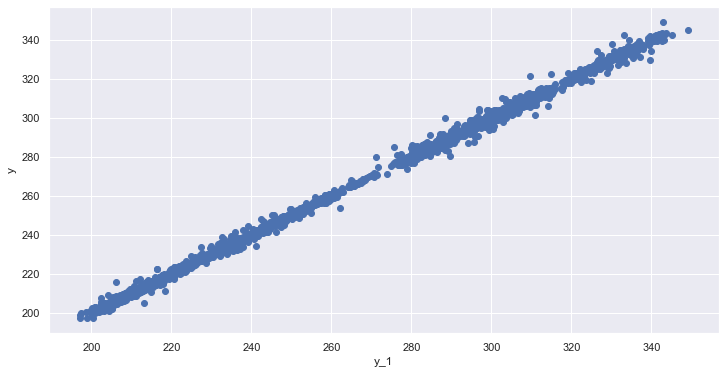

In [322]:
plt.scatter(X_train.y_1, y_train)
plt.xlabel('y_1')
plt.ylabel('y')

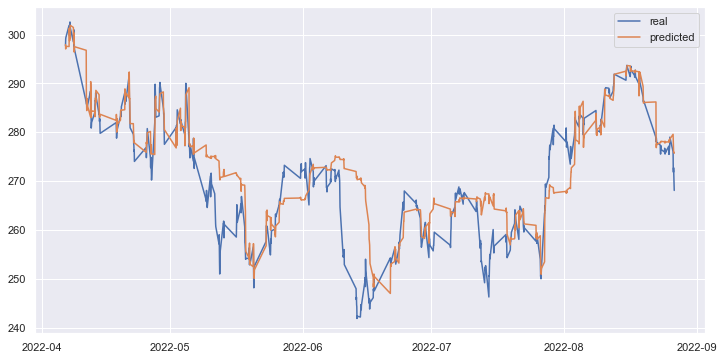

In [323]:
plt.plot(X_test.index, y_test, )
plt.plot(X_test.index, y_pred, )
plt.legend(['real', 'predicted']);

In [324]:
np.mean((np.diff(y_test) > 0) == (np.diff(y_pred) > 0))

0.46734397677793904

In [325]:
X_train.iloc[-1]

y_1     298.149994
y_2     300.570007
y_3     301.513000
y_4     311.010010
y_5     310.940002
           ...    
y_66    298.769989
y_67    299.410004
y_68    300.809998
y_69    301.029999
y_70    300.793701
Name: 2022-04-06 12:30:00-04:00, Length: 70, dtype: float64

In [285]:
steps = 30
seq_predict = predict_sequence(model, X_train.iloc[-1], steps=steps)

C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\artem\anaconda\lib\site-packages\sklearn\base.py:450: UserWar

In [286]:
seq_predict

[297.9514743041992,
 298.2154458618164,
 300.9534625244141,
 305.19725158691404,
 310.94414672851565,
 311.52152252197266,
 311.9735726928711,
 311.6550183105469,
 311.4080850219727,
 312.5183758544922,
 313.3648211669922,
 314.13154174804686,
 313.7183023071289,
 313.59455657958983,
 313.37324890136716,
 313.43134063720703,
 312.94463287353517,
 311.2068569946289,
 308.42708465576175,
 307.6095346069336,
 307.1027813720703,
 306.6756512451172,
 307.33543212890623,
 307.8675814819336,
 308.3305383300781,
 308.90761901855467,
 310.07499237060546,
 311.23934783935545,
 310.9348550415039,
 311.3296701049805]

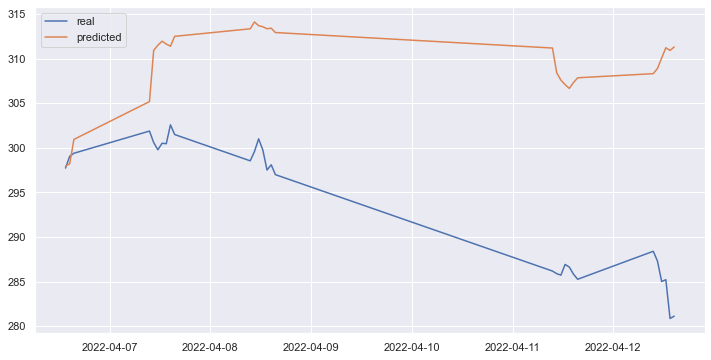

In [288]:
plt.plot(X_test.index[:steps], y_test[:steps], )
plt.plot(X_test.index[:steps], seq_predict, )
plt.legend(['real', 'predicted']);

## Trying classification

In [391]:
X = download_stock_data('MSFT', '1Y', '1h')

In [392]:
X_preproccessed = preproccess_stock_data(X, 30, log_ret=True)
X_preproccessed.head()

y       y_1       y_2       y_3       y_4  \
2021-09-02 12:30:00-04:00 -0.000200 -0.002348 -0.002694  0.001212 -0.002337   
2021-09-02 13:30:00-04:00 -0.000266 -0.000200 -0.002348 -0.002694  0.001212   
2021-09-02 14:30:00-04:00  0.000532 -0.000266 -0.000200 -0.002348 -0.002694   
2021-09-02 15:30:00-04:00  0.001462  0.000532 -0.000266 -0.000200 -0.002348   
2021-09-03 09:30:00-04:00  0.001174  0.001462  0.000532 -0.000266 -0.000200   

                                y_5       y_6       y_7       y_8       y_9  \
2021-09-02 12:30:00-04:00 -0.001387 -0.000924  0.000518 -0.001770 -0.001744   
2021-09-02 13:30:00-04:00 -0.002337 -0.001387 -0.000924  0.000518 -0.001770   
2021-09-02 14:30:00-04:00  0.001212 -0.002337 -0.001387 -0.000924  0.000518   
2021-09-02 15:30:00-04:00 -0.002694  0.001212 -0.002337 -0.001387 -0.000924   
2021-09-03 09:30:00-04:00 -0.002348 -0.002694  0.001212 -0.002337 -0.001387   

                           ...      y_21      y_22      y_23      y_24  \
2021-09-02 12:30:00-04:00  ...  0.001716 -0.002144 -0.000728  0.013229   
2021-09-02 13:30:00-04:00  ...  0.000476  0.001716 -0.002144 -0.000728   
2021-09-02 14:30:00-04:00  ...  0.000118  0.000476  0.001716 -0.002144   
2021-09-02 15:30:00-04:00  ...  0.000165  0.000118  0.000476  0.001716   
2021-09-03 09:30:00-04:00  ... -0.001819  0.000165  0.000118  0.000476   

                               y_25      y_26      y_27      y_28      y_29  \
2021-09-02 12:30:00-04:00  0.000801  0.001007 -0.002442  0.002070  0.001639   
2021-09-02 13:30:00-04:00  0.013229  0.000801  0.001007 -0.002442  0.002070   
2021-09-02 14:30:00-04:00 -0.000728  0.013229  0.000801  0.001007 -0.002442   
2021-09-02 15:30:00-04:00 -0.002144 -0.000728  0.013229  0.000801  0.001007   
2021-09-03 09:30:00-04:00  0.001716 -0.002144 -0.000728  0.013229  0.000801   

                               y_30  
2021-09-02 12:30:00-04:00 -0.002908  
2021-09-02 13:30:00-04:00  0.001639  
2021-09-02 14:30:00-04:00  0.002070  
2021-09-02 15:30:00-04:00 -0.002442  
2021-09-03 09:30:00-04:00  0.001007  

[5 rows x 31 columns]

In [393]:
X_preproccessed.loc[:, 'y'] = (X_preproccessed['y'] > 0).astype(int)
X_preproccessed.head()

y       y_1       y_2       y_3       y_4  \
2021-09-02 12:30:00-04:00  0 -0.002348 -0.002694  0.001212 -0.002337   
2021-09-02 13:30:00-04:00  0 -0.000200 -0.002348 -0.002694  0.001212   
2021-09-02 14:30:00-04:00  1 -0.000266 -0.000200 -0.002348 -0.002694   
2021-09-02 15:30:00-04:00  1  0.000532 -0.000266 -0.000200 -0.002348   
2021-09-03 09:30:00-04:00  1  0.001462  0.000532 -0.000266 -0.000200   

                                y_5       y_6       y_7       y_8       y_9  \
2021-09-02 12:30:00-04:00 -0.001387 -0.000924  0.000518 -0.001770 -0.001744   
2021-09-02 13:30:00-04:00 -0.002337 -0.001387 -0.000924  0.000518 -0.001770   
2021-09-02 14:30:00-04:00  0.001212 -0.002337 -0.001387 -0.000924  0.000518   
2021-09-02 15:30:00-04:00 -0.002694  0.001212 -0.002337 -0.001387 -0.000924   
2021-09-03 09:30:00-04:00 -0.002348 -0.002694  0.001212 -0.002337 -0.001387   

                           ...      y_21      y_22      y_23      y_24  \
2021-09-02 12:30:00-04:00  ...  0.001716 -0.002144 -0.000728  0.013229   
2021-09-02 13:30:00-04:00  ...  0.000476  0.001716 -0.002144 -0.000728   
2021-09-02 14:30:00-04:00  ...  0.000118  0.000476  0.001716 -0.002144   
2021-09-02 15:30:00-04:00  ...  0.000165  0.000118  0.000476  0.001716   
2021-09-03 09:30:00-04:00  ... -0.001819  0.000165  0.000118  0.000476   

                               y_25      y_26      y_27      y_28      y_29  \
2021-09-02 12:30:00-04:00  0.000801  0.001007 -0.002442  0.002070  0.001639   
2021-09-02 13:30:00-04:00  0.013229  0.000801  0.001007 -0.002442  0.002070   
2021-09-02 14:30:00-04:00 -0.000728  0.013229  0.000801  0.001007 -0.002442   
2021-09-02 15:30:00-04:00 -0.002144 -0.000728  0.013229  0.000801  0.001007   
2021-09-03 09:30:00-04:00  0.001716 -0.002144 -0.000728  0.013229  0.000801   

                               y_30  
2021-09-02 12:30:00-04:00 -0.002908  
2021-09-02 13:30:00-04:00  0.001639  
2021-09-02 14:30:00-04:00  0.002070  
2021-09-02 15:30:00-04:00 -0.002442  
2021-09-03 09:30:00-04:00  0.001007  

[5 rows x 31 columns]

In [394]:
from sklearn.linear_model import RidgeClassifierCV, ElasticNetCV

In [402]:
model = ElasticNetCV(cv=tscv, alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0))
model.fit(X_train, y_train)
model.alphas_

array([1.e+02, 5.e+01, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [403]:
from sklearn.metrics import accuracy_score

In [404]:
validate_model(model, X_test, y_test, [accuracy_score, ])

ValueError: Classification metrics can't handle a mix of binary and continuous targets